# Business objective

Group customers into distinct segments and analyze purchasing patterns to identify opportunities for increasing sales and revenue.

In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans , AgglomerativeClustering
from scipy.cluster import hierarchy

In [151]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Reading and inspecting data

In [3]:
df = pd.read_csv('Mall_Customers.csv')

In [4]:
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [27]:
gender_dict = dict(df['Genre'].value_counts(normalize=True))
gender_dict

{'Female': 0.56, 'Male': 0.44}

# EDA

**Relationship between income and spending**

In [23]:
px.scatter(df, x = 'Annual Income (k$)' , y='Spending Score (1-100)' , size='Age' , color='Genre')

We can see that customers fall into five categories :
* Low income , low spending ( Poor `older people` )
* Low income , high spending ( `Younger people and teenagers` )
* Medium income , Medium spending ( The biggest group , `all ages so this group can be divided into two groups younger and older` )
* High income , High spending ( Rich younger people in their `20s or 30s` )
* High income , low spending ( Rich `older people` )

**We can see that the age group has clear effect on spending attitude , young people are more likely to be in the high spending category regardless of their income .**

### Relationship between age and spending

<AxesSubplot:xlabel='Age', ylabel='Spending Score (1-100)'>

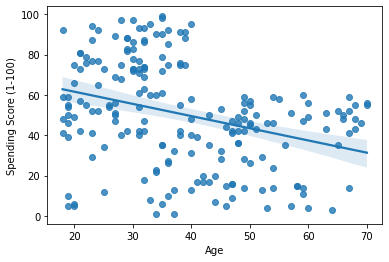

In [17]:
sns.regplot(x = df['Age'] , y=df['Spending Score (1-100)'])

* All People older than 40 have spending score <= 60
* All people have spending score > 60 are younger than 40

### Distribution of Age , Income and Spending

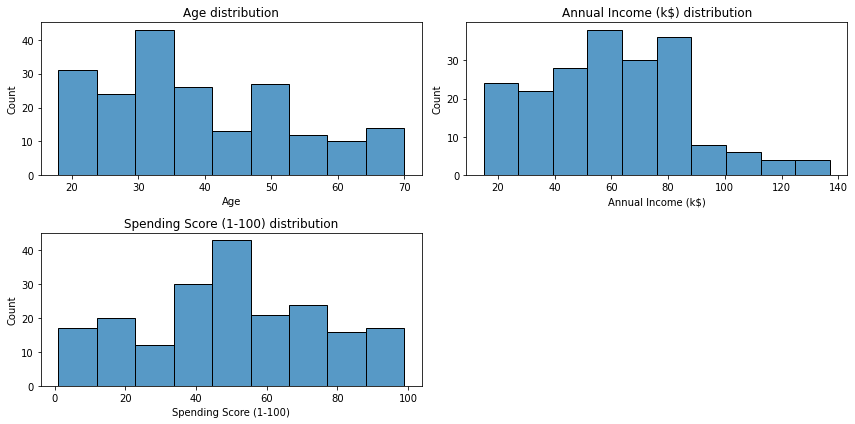

In [11]:
cols = ['Age' , 'Annual Income (k$)','Spending Score (1-100)']
fig , axes = plt.subplots(2,2 , figsize=(12,6))

sns.histplot(data=df , x='Age' , ax = axes[0,0])
axes[0, 0].set_title('Age distribution')

sns.histplot(data=df , x='Annual Income (k$)' , ax = axes[0,1])
axes[0, 1].set_title('Annual Income (k$) distribution')

sns.histplot(data=df , x='Spending Score (1-100)' , ax = axes[1,0])
axes[1, 0].set_title('Spending Score (1-100) distribution')

axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

### Gender Percentage

In [30]:
px.pie(values = gender_dict.values() , names = gender_dict.keys())

# Data preprocessing

In [37]:
X = df[cols]

In [38]:
ss = StandardScaler()

In [39]:
X = ss.fit_transform(X)

# KMeans Clustering

* Choose the number of clusters k based on domain knowledge or elbow method
* Initialize k centroids one for each cluster, These are chosen randomly from the data points
* Assign each data point to the nearest centroid using the Euclidean distance 
* Recalculate the centroids of each cluster, This is done by taking the mean of all the data points assigned to each centroid ,
so the new centroid positions are the average of the points in each cluster.
* Repeat the assignment and update steps until the centroids no longer change significantly or until a predefined number of iterations is reached
 

In [78]:
data = df.copy()

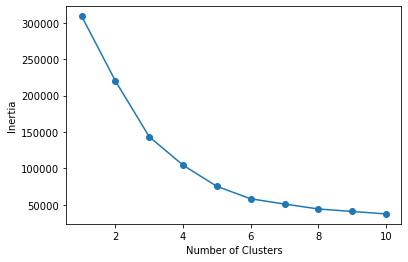

In [79]:
inertia = []
list_num_clusters = list(range(1,11))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters)
    km.fit(data[cols])
    inertia.append(km.inertia_)
    
plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');

In [80]:
km = KMeans(n_clusters=6, random_state=42)
km.fit(data[cols])

KMeans(n_clusters=6, random_state=42)

In [81]:
data['kmeansclusters'] = km.labels_

In [82]:
px.scatter(data , x='Annual Income (k$)' , y = 'Spending Score (1-100)', size='Age' , color='kmeansclusters')

**Although people in the middle cluster have the same spending attitude and income , it has been divided into two groups the older and younger peole .**

# Agglomerative heirarchial clustering

* Start with each data point as its own individual cluster, If we have n data points then we initially have n clusters
* Compute the distance between all pairs of clusters. Initially, this means calculating the distance between every pair of individual data points.
* Identify the two clusters that are closest to each other based on a distance metric, like Euclidean distance and merge them into a single cluster.
* Recalculate the distances between the newly formed cluster and all other clusters. This step depends on the linkage criterion used :
    * Single Linkage: Distance between the closest pair of points from different clusters.
    * Complete Linkage: Distance between the farthest pair of points from different clusters.
    * Average Linkage: Average distance between all pairs of points from different clusters.
    * Ward’s Method: Minimizes the variance within clusters.
* Repeat the merging and distance updating steps until only one cluster remains a complete hierarchical tree or dendrogram is built or until the desired number of clusters is achieved.

In [88]:
AgModel = AgglomerativeClustering(n_clusters=6, linkage='ward', compute_full_tree=True)
AgModel.fit(data[cols])

AgglomerativeClustering(compute_full_tree=True, n_clusters=6)

In [89]:
data['aggclusters'] = AgModel.fit_predict(data[cols])

In [95]:
px.scatter(data , x='Annual Income (k$)' , y = 'Spending Score (1-100)', size='Age' , color='aggclusters')

In [96]:
px.scatter_3d(data , x='Annual Income (k$)' , y = 'Spending Score (1-100)' , z='Age', size='Age' , color='aggclusters')

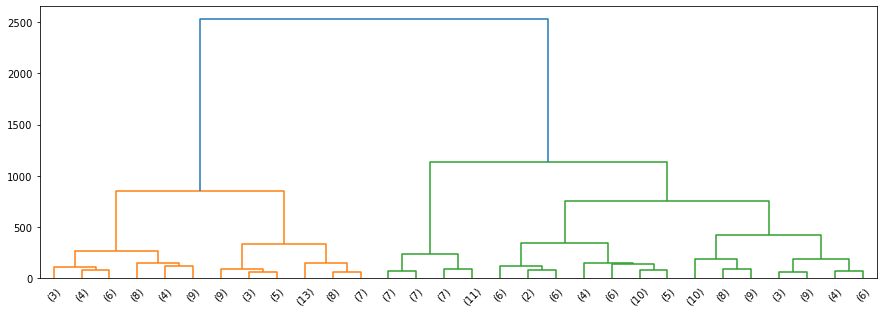

In [157]:
Z = hierarchy.linkage(ag.children_, method='ward')

fig, ax = plt.subplots(figsize=(15,5))


den = hierarchy.dendrogram(Z, orientation='top', 
                           p=30, truncate_mode='lastp',
                           ax=ax)

* **The dendrogram provides a visual representation of the merging process and can help determine the optimal number of clusters by cutting the tree at a desired level.**
* **Vertical axis represents the distances at which the merge happens**
* **Horizontal axis represents number of data points in each cluster**